In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from WindPy import w
w.start()

.ErrorCode=0
.Data=[Already conntected!]

In [38]:
def stock_data(stockList, factor, startDate, endDate):
    data = w.wsd(stockList, factor, startDate, endDate, "")
    df = pd.DataFrame(data.Data, columns = data.Times, index = stockList).T
    return df

## 数据初始设置

In [39]:
stockList = ["000300.SH","000016.SH","000905.SH","399006.SZ","399005.SZ","881001.WI","000001.SH"]
stockList = ["000300.SH","000016.SH","000905.SH","399005.SZ","881001.WI","000001.SH"]
stockList = ["000300.SH"]

startDate = "20080101"
endDate = "20210101"
N = 1 # N-month return of index

## 对所选指数的PE取倒数

In [40]:
stockPEdf = stock_data(stockList, "pe_ttm", startDate, endDate)
bond10y = w.edb("M1001654", startDate, endDate)
bonddf = pd.DataFrame(bond10y.Data,columns = bond10y.Times, index = ["bond10y"]).T/100
merged_data = pd.concat([1/stockPEdf,bonddf],axis = 1,join = 'inner')

## 7种指数与十年国债的收益比

In [41]:
returnRatio = pd.DataFrame(index = stockList,columns = merged_data.index).T
for i in stockList:
    returnRatio[i] = merged_data[i].T / merged_data[merged_data.columns[-1]].T
returnRatio = np.around(returnRatio, decimals = 2, out = None)

            沪深300   上证50   中证500   创业板指  中小板指  万得全A   上证指数

In [42]:
returnRatio

,000300.SH
2008-01-02,0.50
2008-01-03,0.50
2008-01-04,0.50
2008-01-07,0.49
2008-01-08,0.49
...,...
2020-12-25,2.00
2020-12-28,2.01
2020-12-29,2.03
2020-12-30,2.02


## 七种指数  $ log \frac{P_{t+T}}{P_t} $  计算N月收益涨跌 (一年约250个交易日 250/N）

In [43]:
def calculateReturn(N,stockList,factor,startDate, endDate):
    stockClosedf = stock_data(stockList, factor, startDate, endDate)
    days = round(250/12 * N)
    upAndDown = np.log(stockClosedf.shift(-days)/stockClosedf).fillna(value = 0)
    upAndDown = np.around(upAndDown, decimals = 4, out = None)
    
    #make sure indexes of both returnRatio and upAndDown are same
    #Caution:  some possible bugs here when len(returnRatio) > len(upAndDown) !!!!!!
    for i in range(0,min(len(returnRatio), len(upAndDown))):
        if returnRatio.index[i] != upAndDown.index[i]:
            upAndDown.drop(upAndDown.index[i],inplace = True)
    
    return upAndDown

In [44]:
calculateReturn(N,stockList, "CLOSE", startDate, endDate)

,000300.SH
2008-01-02,-0.1532
2008-01-03,-0.1705
2008-01-04,-0.1024
2008-01-07,-0.1213
2008-01-08,-0.1379
...,...
2020-12-25,0.0000
2020-12-28,0.0000
2020-12-29,0.0000
2020-12-30,0.0000


## 七种指数涨跌，0代表跌，1代表涨

In [45]:
upAndDown = calculateReturn(N,stockList, "CLOSE", startDate, endDate)

In [46]:
def representation(upAndDown):
    y = pd.DataFrame(index = upAndDown.columns,columns = upAndDown.index).T
    for i in range(0,len(upAndDown)):
        for j in range(0,len(upAndDown.iloc[i])):
            if upAndDown.iloc[i][j] > 0:
                y.iloc[i][j] = 1
            else:
                y.iloc[i][j] = 0
    return y

In [47]:
Y_representation = representation(upAndDown)

In [48]:
Y_representation

,000300.SH
2008-01-02,0
2008-01-03,0
2008-01-04,0
2008-01-07,0
2008-01-08,0
...,...
2020-12-25,0
2020-12-28,0
2020-12-29,0
2020-12-30,0


In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [50]:
import random
def randomcolor():
    colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
    color = ""
    for i in range(6):
        color += colorArr[random.randint(0,14)]
    return "#"+color

## 多项式回归分析

In [51]:
def Polynomial(returnRatio,upAndDown,m):
    poly = PolynomialFeatures(degree = 10)
    X = returnRatio.iloc[:,m:m+1].values
    X_transformed = poly.fit_transform(X)
    Y = upAndDown.iloc[:,m].values
    lin = LinearRegression()
    lin.fit(X_transformed,Y)
    Y_prediction = lin.predict(X_transformed)
    return [X,Y,Y_prediction]

## 基于股债比预测未来一个月的月收益率

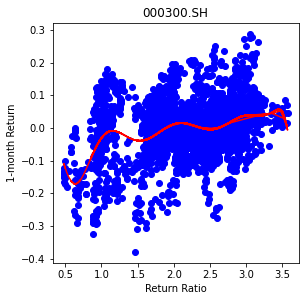

In [52]:
plt.figure(figsize=(15,15))
N = 1
upAndDown = calculateReturn(N,stockList, "CLOSE", startDate, endDate)
for i in range(len(stockList)):
    a = Polynomial(returnRatio,upAndDown,i)
    plt.subplot(331+i)
    plt.scatter(a[0],a[1],color = 'blue')
    plt.plot(a[0],a[2],color = 'red')
    plt.title(stockList[i])
    plt.xlabel('Return Ratio') 
    plt.ylabel(str(N)+'-month Return') 

## 基于股债比预测未来一个季度的季度收益率

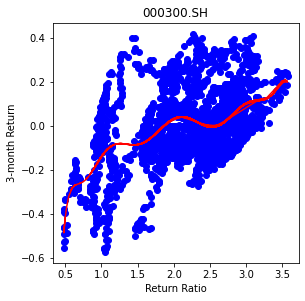

In [53]:
plt.figure(figsize=(15,15))
N = 3
upAndDown = calculateReturn(N,stockList, "CLOSE", startDate, endDate)
for i in range(len(stockList)):
    a = Polynomial(returnRatio,upAndDown,i)
    plt.subplot(331+i)
    plt.scatter(a[0],a[1],color = 'blue')
    plt.plot(a[0],a[2],color = 'red')
    plt.title(stockList[i])
    plt.xlabel('Return Ratio') 
    plt.ylabel(str(N)+'-month Return') 

## 基于股债比预测未来半年的半年收益率

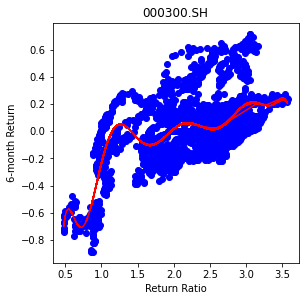

In [54]:
plt.figure(figsize=(15,15))
N = 6
upAndDown = calculateReturn(N,stockList, "CLOSE", startDate, endDate)
for i in range(len(stockList)):
    a = Polynomial(returnRatio,upAndDown,i)
    plt.subplot(331+i)
    plt.scatter(a[0],a[1],color = 'blue')
    plt.plot(a[0],a[2],color = 'red')
    plt.title(stockList[i])
    plt.xlabel('Return Ratio') 
    plt.ylabel(str(N)+'-month Return') 

## 基于股债比预测未来一年的年收益率

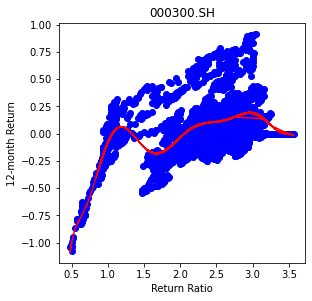

In [55]:
plt.figure(figsize=(15,15))
N = 12
upAndDown = calculateReturn(N,stockList, "CLOSE", startDate, endDate)
for i in range(len(stockList)):
    a = Polynomial(returnRatio,upAndDown,i)
    plt.subplot(331+i)
    plt.scatter(a[0],a[1],color = 'blue')
    plt.plot(a[0],a[2],color = 'red')
    plt.title(stockList[i])
    plt.xlabel('Return Ratio') 
    plt.ylabel(str(N)+'-month Return') 

Text(0, 0.5, '12-month Return')

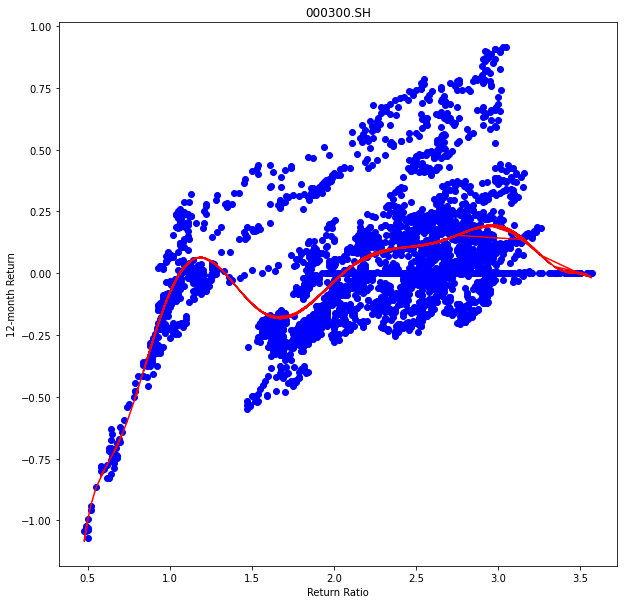

In [57]:
i = 0
N = 12
upAndDown = calculateReturn(N,stockList, "CLOSE", startDate, endDate)
a = Polynomial(returnRatio,upAndDown,i)
plt.figure(figsize=(10,10))
plt.scatter(a[0],a[1],color = 'blue')
plt.plot(a[0],a[2],color = 'red')
plt.title(stockList[i])
plt.xlabel('Return Ratio') 
plt.ylabel(str(N)+'-month Return') 

## 历史每个股债比N个月后指数涨跌概率

In [58]:
def getListAll(returnRatio, upAndDown, Y_representation, m):
    listAll = []
    a = Polynomial(returnRatio,upAndDown,m)
    for i in np.arange(min(a[0]),max(a[0])+0.01, 0.01):
        i = np.around(i, decimals = 2, out = None)
        list_temp = [i]
        for j in range(0,len(a[0])):
            if a[0][j][0] == i:
                list_temp.append(Y_representation.iloc[:,m].values[j])
        listAll.append(list_temp)    
    return listAll

In [59]:
def getStatAll(listAll):
    statAll = []
    X_plt = []
    Y_plt = []
    for i in listAll:
        stat_temp = [i[0]]
        count0 = 0
        count1 = 0
        for j in i[1:]:
            if j == 0:
                count0+=1
            else:
                count1+=1
        count = count0 + count1
        if count!=0:
            probability_up = count1/count
            stat_temp.append(probability_up)
        else:
            stat_temp.append(statAll[listAll.index(stat_temp)-1][1])
        X_plt.append(np.float(stat_temp[0]))
        Y_plt.append(stat_temp[1])
        statAll.append(stat_temp)
    return [X_plt,Y_plt,statAll]

## 历史每个股债比1个月后指数涨跌概率

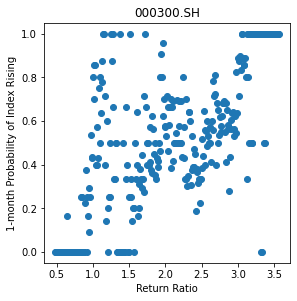

In [60]:
plt.figure(figsize=(15,15))
N = 1
upAndDown = calculateReturn(N,stockList, "CLOSE", startDate, endDate)
Y_representation = representation(upAndDown)
for i in range(len(stockList)):
    listAll = getListAll(returnRatio, upAndDown, Y_representation, i)
    a = getStatAll(listAll)
    plt.subplot(331+i)
    plt.plot(a[0],a[1],'o')
    plt.title(stockList[i])
    plt.xlabel('Return Ratio') 
    plt.ylabel(str(N)+'-month Probability of Index Rising') 

## 历史每个股债比3个月后指数涨跌概率

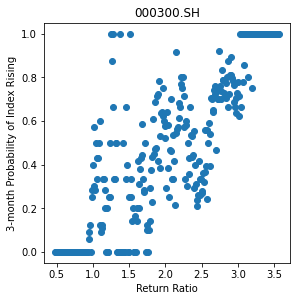

In [61]:
plt.figure(figsize=(15,15))
N = 3
upAndDown = calculateReturn(N,stockList, "CLOSE", startDate, endDate)
Y_representation = representation(upAndDown)
for i in range(len(stockList)):
    listAll = getListAll(returnRatio, upAndDown, Y_representation, i)
    a = getStatAll(listAll)
    plt.subplot(331+i)
    plt.plot(a[0],a[1],'o')
    plt.title(stockList[i])
    plt.xlabel('Return Ratio') 
    plt.ylabel(str(N)+'-month Probability of Index Rising') 

## 历史每个股债比6个月后指数涨跌概率

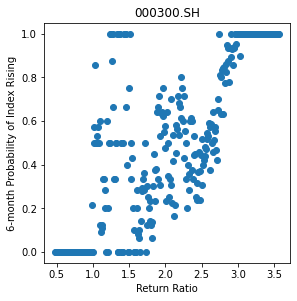

In [62]:
plt.figure(figsize=(15,15))
N = 6
upAndDown = calculateReturn(N,stockList, "CLOSE", startDate, endDate)
Y_representation = representation(upAndDown)
for i in range(len(stockList)):
    listAll = getListAll(returnRatio, upAndDown, Y_representation, i)
    a = getStatAll(listAll)
    plt.subplot(331+i)
    plt.plot(a[0],a[1],'o')
    plt.title(stockList[i])
    plt.xlabel('Return Ratio') 
    plt.ylabel(str(N)+'-month Probability of Index Rising') 

Text(0, 0.5, '1-month Probability of Index Rising')

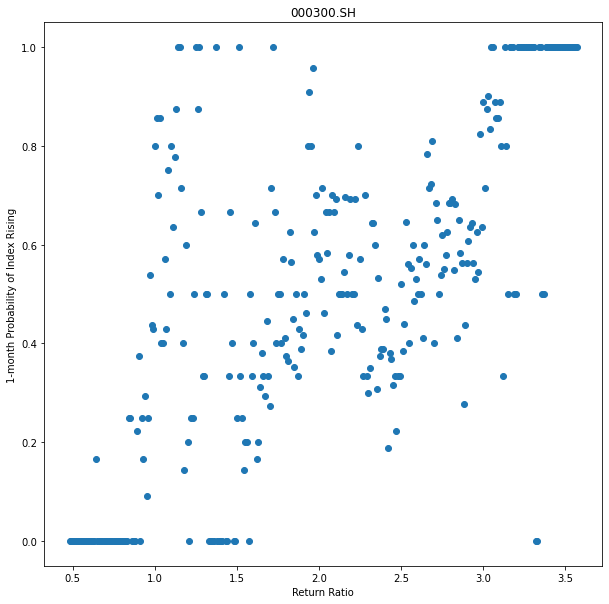

In [63]:
i = 0
N = 1
upAndDown = calculateReturn(N,stockList, "CLOSE", startDate, endDate)
Y_representation = representation(upAndDown)
listAll = getListAll(returnRatio, upAndDown, Y_representation, i)
a = getStatAll(listAll)
plt.figure(figsize=(10,10))
plt.plot(a[0],a[1],'o')
plt.title(stockList[i])
plt.xlabel('Return Ratio') 
plt.ylabel(str(N)+ '-month Probability of Index Rising') 

## 股债比重新排序并对应其所在百分位（打乱排序，不考虑时间顺序）

In [64]:
#pd.set_option('display.max_rows', None)

In [65]:
data_sorted = pd.DataFrame()
for i in returnRatio:
    ratio_sorted = pd.DataFrame(returnRatio[i].sort_values().values, columns = [i])
    percentile = pd.DataFrame(returnRatio[i].sort_values().rank(pct=True).values, columns = ['percentile'])
    data_sorted = pd.concat([data_sorted, pd.concat([ratio_sorted,percentile],axis = 1)], axis =1)

In [66]:
data_sorted

,000300.SH,percentile
0,0.48,0.000316
1,0.49,0.001423
2,0.49,0.001423
3,0.49,0.001423
4,0.49,0.001423
...,...,...
3158,3.54,0.998893
3159,3.54,0.998893
3160,3.56,0.999526
3161,3.56,0.999526


## 十个股债比区间按如下配置比进行回测

In [67]:
weights_original = np.around([i for i in np.arange(0.1,1.1,0.1)],decimals = 2)

In [68]:
weights_original

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [69]:
dailyReturnOfBond = 0.04/365
stockClosedf = stock_data(stockList, 'CLOSE', startDate, endDate)
N_sect = 10

In [70]:
def weight_stock(m, ratio, weights):
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
    return np.around(weights[index],decimals =2)

In [71]:
def updateMoney(t,t_lasttime,weights,money):
    bondIncome = (t-t_lasttime).days * dailyReturnOfBond * (1-weights) * money
    stockIncome = (stockClose[t]-stockClose[t_lasttime])/stockClose[t_lasttime] * weights * money
    money += (stockIncome + bondIncome)
    return money

## 08年-20年底 沪深300走势(左y轴)与其股债比(右y轴)

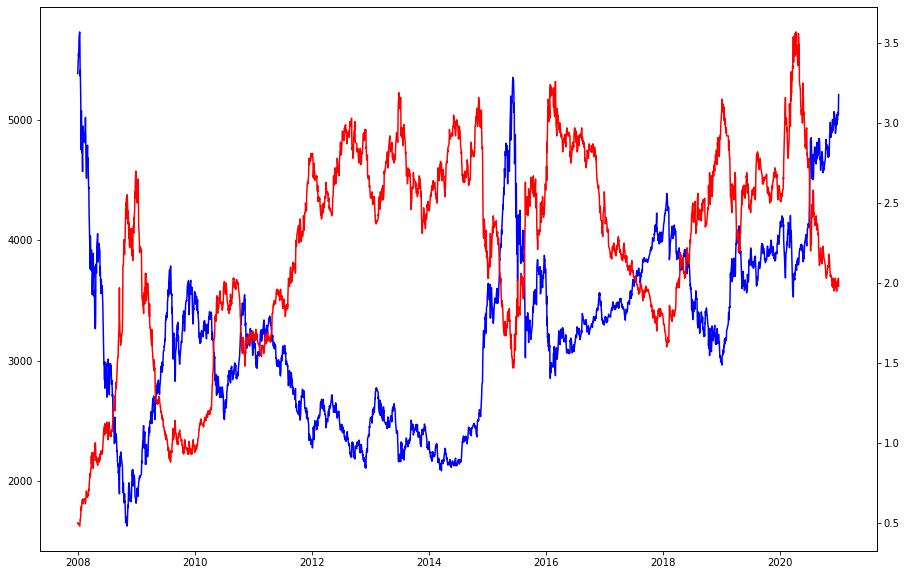

In [72]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(111)
ax1.plot(stockClosedf['000300.SH'],color = 'blue')
ax2 = ax1.twinx() 
ax2.plot(returnRatio['000300.SH'],color = 'red')

## 08年-20年底 (共13年) 按照股债比变化调仓

In [73]:
for stock in returnRatio:
    m = returnRatio[stock]
    stockClose = stockClosedf[stock]
    weights_assigned = [i for i in np.arange(0.1,1.1,0.1)]
    
    weights_new = weights_lasttime = weight_stock(m,m[0],weights_assigned)
    t = t_lasttime = m.index[0]
    money = 1
    
    for i in range(1,len(m)):     
        weights_new = weight_stock(m,m[i],weights_assigned)
#         if i%21 == 0:
        if weights_new != weights_lasttime:
            t = m.index[i]
            money = updateMoney(t,t_lasttime, weights_lasttime,money)
            weights_lasttime = weights_new
            t_lasttime = t
    print(stock)
    print("指数总收益率： " + str(stockClose[-1]/stockClose[0] - 1) + "   指数年化收益率： " + str((stockClose[-1]/stockClose[0])**(1/13) - 1))
    print("策略总收益率： " + str(money - 1) + "   策略年化收益率： " + str(money**(1/13) - 1))

000300.SH
指数总收益率： -0.03227691280928158   指数年化收益率： -0.0025206101893705535
策略总收益率： 1.5661917188789976   策略年化收益率： 0.07518643587914542


## 08年-20年底 (共13年) 按月调仓

In [74]:
for stock in returnRatio:
    m = returnRatio[stock]
    stockClose = stockClosedf[stock]
    weights_assigned = [i for i in np.arange(0.1,1.1,0.1)]
    
    weights_new = weights_lasttime = weight_stock(m,m[0],weights_assigned)
    t = t_lasttime = m.index[0]
    money = 1
    
    for i in range(1,len(m)):     
        weights_new = weight_stock(m,m[i],weights_assigned)
        if i%21 == 0:
#         if weights_new != weights_lasttime:
            t = m.index[i]
            money = updateMoney(t,t_lasttime, weights_lasttime,money)
            weights_lasttime = weights_new
            t_lasttime = t
    print(stock)
    print("指数总收益率： " + str(stockClose[-1]/stockClose[0] - 1) + "   指数年化收益率： " + str((stockClose[-1]/stockClose[0])**(1/13) - 1))
    print("策略总收益率： " + str(money - 1) + "   策略年化收益率： " + str(money**(1/13) - 1))

000300.SH
指数总收益率： -0.03227691280928158   指数年化收益率： -0.0025206101893705535
策略总收益率： 1.6489833011626565   策略年化收益率： 0.07781582402081977


## 09年-20年底 (共12年) 按照股债比变化调仓

In [75]:
startDate = "20090101"
stockPEdf = stock_data(stockList, "pe_ttm", startDate, endDate)
bond10y = w.edb("M1001654", startDate, endDate)
bonddf = pd.DataFrame(bond10y.Data,columns = bond10y.Times, index = ["bond10y"]).T/100
merged_data = pd.concat([1/stockPEdf,bonddf],axis = 1,join = 'inner')

returnRatio = pd.DataFrame(index = stockList,columns = merged_data.index).T
for i in stockList:
    returnRatio[i] = merged_data[i].T / merged_data[merged_data.columns[-1]].T
returnRatio = np.around(returnRatio, decimals = 2, out = None)

stockClosedf = stock_data(stockList, 'CLOSE', startDate, endDate)

for stock in returnRatio:
    m = returnRatio[stock]
    stockClose = stockClosedf[stock]
    weights_assigned = [i for i in np.arange(0.1,1.1,0.1)]
    
    weights_new = weights_lasttime = weight_stock(m,m[0],weights_assigned)
    t = t_lasttime = m.index[0]
    money = 1
    
    for i in range(1,len(m)):     
        weights_new = weight_stock(m,m[i],weights_assigned)
#         if i%21 == 0:
        if weights_new != weights_lasttime:
            t = m.index[i]
            money = updateMoney(t,t_lasttime, weights_lasttime,money)
            weights_lasttime = weights_new
            t_lasttime = t
    print(stock)
    print("指数总收益率： " + str(stockClose[-1]/stockClose[0] - 1) + "   指数年化收益率： " + str((stockClose[-1]/stockClose[0])**(1/12) - 1))
    print("策略总收益率： " + str(money - 1) + "   策略年化收益率： " + str(money**(1/12) - 1))

000300.SH
指数总收益率： 1.7676059330022582   指数年化收益率： 0.08853405625683264
策略总收益率： 1.9503551896046152   策略年化收益率： 0.09434987322541044


## 09年-20年底 (共12年) 按月调仓

In [76]:
for stock in returnRatio:
    m = returnRatio[stock]
    stockClose = stockClosedf[stock]
    weights_assigned = [i for i in np.arange(0.1,1.1,0.1)]
    
    weights_new = weights_lasttime = weight_stock(m,m[0],weights_assigned)
    t = t_lasttime = m.index[0]
    money = 1
    
    for i in range(1,len(m)):     
        weights_new = weight_stock(m,m[i],weights_assigned)
        if i%21 == 0:
#         if weights_new != weights_lasttime:
            t = m.index[i]
            money = updateMoney(t,t_lasttime, weights_lasttime,money)
            weights_lasttime = weights_new
            t_lasttime = t
    print(stock)
    print("指数总收益率： " + str(stockClose[-1]/stockClose[0] - 1) + "   指数年化收益率： " + str((stockClose[-1]/stockClose[0])**(1/12) - 1))
    print("策略总收益率： " + str(money - 1) + "   策略年化收益率： " + str(money**(1/12) - 1))

000300.SH
指数总收益率： 1.7676059330022582   指数年化收益率： 0.08853405625683264
策略总收益率： 2.2393156722600347   策略年化收益率： 0.10290415456510504


## 11年-20年底 (共10年) 按照股债比变化调仓

In [77]:
startDate = "20110101"
stockPEdf = stock_data(stockList, "pe_ttm", startDate, endDate)
bond10y = w.edb("M1001654", startDate, endDate)
bonddf = pd.DataFrame(bond10y.Data,columns = bond10y.Times, index = ["bond10y"]).T/100
merged_data = pd.concat([1/stockPEdf,bonddf],axis = 1,join = 'inner')

returnRatio = pd.DataFrame(index = stockList,columns = merged_data.index).T
for i in stockList:
    returnRatio[i] = merged_data[i].T / merged_data[merged_data.columns[-1]].T
returnRatio = np.around(returnRatio, decimals = 2, out = None)

stockClosedf = stock_data(stockList, 'CLOSE', startDate, endDate)

for stock in returnRatio:
    m = returnRatio[stock]
    stockClose = stockClosedf[stock]
    weights_assigned = [i for i in np.arange(0.1,1.1,0.1)]
    
    weights_new = weights_lasttime = weight_stock(m,m[0],weights_assigned)
    t = t_lasttime = m.index[0]
    money = 1
    
    for i in range(1,len(m)):     
        weights_new = weight_stock(m,m[i],weights_assigned)
#         if i%21 == 0:
        if weights_new != weights_lasttime:
            t = m.index[i]
            money = updateMoney(t,t_lasttime, weights_lasttime,money)
            weights_lasttime = weights_new
            t_lasttime = t
    print(stock)
    print("指数总收益率： " + str(stockClose[-1]/stockClose[0] - 1) + "   指数年化收益率： " + str((stockClose[-1]/stockClose[0])**(1/10) - 1))
    print("策略总收益率： " + str(money - 1) + "   策略年化收益率： " + str(money**(1/10) - 1))

000300.SH
指数总收益率： 0.6337956260216535   指数年化收益率： 0.050315495849283964
策略总收益率： 1.3459315486380108   策略年化收益率： 0.08900916205621567


## 11年-20年底 (共10年) 按月调仓

In [78]:
for stock in returnRatio:
    m = returnRatio[stock]
    stockClose = stockClosedf[stock]
    weights_assigned = [i for i in np.arange(0.1,1.1,0.1)]
    
    weights_new = weights_lasttime = weight_stock(m,m[0],weights_assigned)
    t = t_lasttime = m.index[0]
    money = 1
    
    for i in range(1,len(m)):     
        weights_new = weight_stock(m,m[i],weights_assigned)
        if i%21 == 0:
#         if weights_new != weights_lasttime:
            t = m.index[i]
            money = updateMoney(t,t_lasttime, weights_lasttime,money)
            weights_lasttime = weights_new
            t_lasttime = t
    print(stock)
    print("指数总收益率： " + str(stockClose[-1]/stockClose[0] - 1) + "   指数年化收益率： " + str((stockClose[-1]/stockClose[0])**(1/10) - 1))
    print("策略总收益率： " + str(money - 1) + "   策略年化收益率： " + str(money**(1/10) - 1))

000300.SH
指数总收益率： 0.6337956260216535   指数年化收益率： 0.050315495849283964
策略总收益率： 1.3982319923271258   策略年化收益率： 0.09141299191910002


## 15年-20年底 (共6年) 按照股债比变化调仓

In [79]:
startDate = "20150101"
stockPEdf = stock_data(stockList, "pe_ttm", startDate, endDate)
bond10y = w.edb("M1001654", startDate, endDate)
bonddf = pd.DataFrame(bond10y.Data,columns = bond10y.Times, index = ["bond10y"]).T/100
merged_data = pd.concat([1/stockPEdf,bonddf],axis = 1,join = 'inner')

returnRatio = pd.DataFrame(index = stockList,columns = merged_data.index).T
for i in stockList:
    returnRatio[i] = merged_data[i].T / merged_data[merged_data.columns[-1]].T
returnRatio = np.around(returnRatio, decimals = 2, out = None)

stockClosedf = stock_data(stockList, 'CLOSE', startDate, endDate)

for stock in returnRatio:
    m = returnRatio[stock]
    stockClose = stockClosedf[stock]
    weights_assigned = [i for i in np.arange(0.1,1.1,0.1)]
    
    weights_new = weights_lasttime = weight_stock(m,m[0],weights_assigned)
    t = t_lasttime = m.index[0]
    money = 1
    
    for i in range(1,len(m)):     
        weights_new = weight_stock(m,m[i],weights_assigned)
#         if i%21 == 0:
        if weights_new != weights_lasttime:
            t = m.index[i]
            money = updateMoney(t,t_lasttime, weights_lasttime,money)
            weights_lasttime = weights_new
            t_lasttime = t
    print(stock)
    print("指数总收益率： " + str(stockClose[-1]/stockClose[0] - 1) + "   指数年化收益率： " + str((stockClose[-1]/stockClose[0])**(1/6) - 1))
    print("策略总收益率： " + str(money - 1) + "   策略年化收益率： " + str(money**(1/6) - 1))

000300.SH
指数总收益率： 0.43106682033787336   指数年化收益率： 0.06155700078482851
策略总收益率： 0.6942167768935763   策略年化收益率： 0.09184627388824707


## 15年-20年底 (共6年) 按月调仓

In [80]:
for stock in returnRatio:
    m = returnRatio[stock]
    stockClose = stockClosedf[stock]
    weights_assigned = [i for i in np.arange(0.1,1.1,0.1)]
    
    weights_new = weights_lasttime = weight_stock(m,m[0],weights_assigned)
    t = t_lasttime = m.index[0]
    money = 1
    
    for i in range(1,len(m)):     
        weights_new = weight_stock(m,m[i],weights_assigned)
        if i%21 == 0:
#         if weights_new != weights_lasttime:
            t = m.index[i]
            money = updateMoney(t,t_lasttime, weights_lasttime,money)
            weights_lasttime = weights_new
            t_lasttime = t
    print(stock)
    print("指数总收益率： " + str(stockClose[-1]/stockClose[0] - 1) + "   指数年化收益率： " + str((stockClose[-1]/stockClose[0])**(1/6) - 1))
    print("策略总收益率： " + str(money - 1) + "   策略年化收益率： " + str(money**(1/6) - 1))

000300.SH
指数总收益率： 0.43106682033787336   指数年化收益率： 0.06155700078482851
策略总收益率： 0.6545714687061086   策略年化收益率： 0.08754588261480323


In [81]:
for stock in returnRatio:
    T = []
    weights_allocated = []
    
    m = returnRatio[stock]
    stockClose = stockClosedf[stock]
    weights_assigned = [i for i in np.arange(0.1,1.1,0.1)]
    
    weights_new = weights_lasttime = weight_stock(m,m[0],weights_assigned)
    weights_allocated.append(weights_new)
    t = t_lasttime = m.index[0]
    T.append(t)
    
    money = 1
    
    for i in range(1,len(m)):     
        weights_new = weight_stock(m,m[i],weights_assigned)
#         if i%21 == 0:
        if weights_new != weights_lasttime:
            t = m.index[i]
            T.append(t)
            weights_allocated.append(weights_new)
            money = updateMoney(t,t_lasttime, weights_lasttime,money)
            weights_lasttime = weights_new
            t_lasttime = t
            
    break

## 蓝线 沪深300走势(左y轴); 红线 股债配置比(右y轴)   (按照股债比变化调仓)

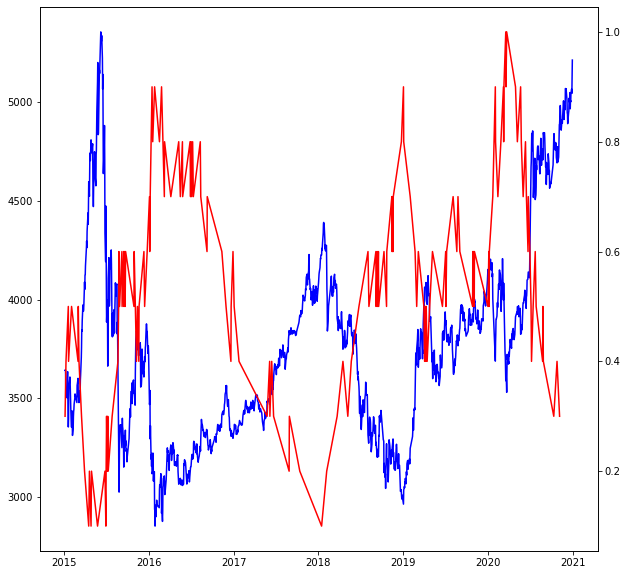

In [82]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.plot(stockClose,color = 'blue')
ax2 = ax1.twinx() 
ax2.plot(T,weights_allocated,color = 'red')

In [83]:
for stock in returnRatio:
    T = []
    weights_allocated = []
    
    m = returnRatio[stock]
    stockClose = stockClosedf[stock]
    weights_assigned = [i for i in np.arange(0.1,1.1,0.1)]
    
    weights_new = weights_lasttime = weight_stock(m,m[0],weights_assigned)
    weights_allocated.append(weights_new)
    t = t_lasttime = m.index[0]
    T.append(t)
    
    money = 1
    
    for i in range(1,len(m)):     
        weights_new = weight_stock(m,m[i],weights_assigned)
        if i%21 == 0:
#         if weights_new != weights_lasttime:
            t = m.index[i]
            T.append(t)
            weights_allocated.append(weights_new)
            money = updateMoney(t,t_lasttime, weights_lasttime,money)
            weights_lasttime = weights_new
            t_lasttime = t
            
    break

## 蓝线 沪深300走势(左y轴); 红线 股债配置比(右y轴)   (按月调仓)

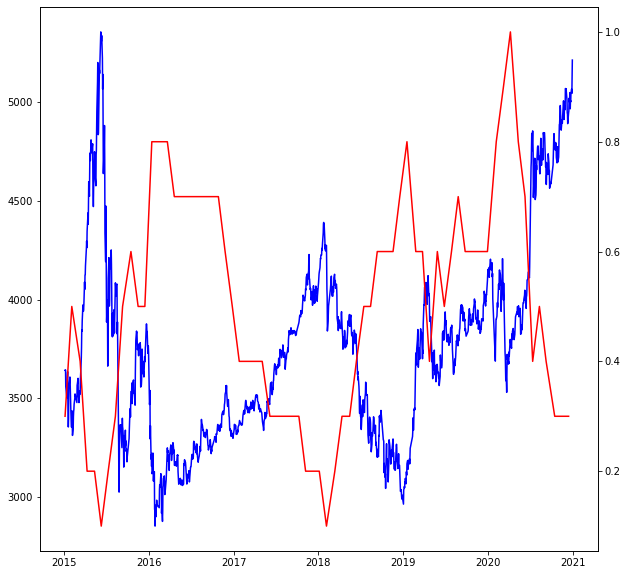

In [84]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.plot(stockClose,color = 'blue')
ax2 = ax1.twinx() 
ax2.plot(T,weights_allocated,color = 'red')

In [85]:
def model(weights_assigned):
    stock = returnRatio.columns[0]
    m = returnRatio[stock]
    stockClose = stockClosedf[stock]
    
    weights_new = weights_lasttime = weight_stock(m,m[0],weights_assigned)
    t = t_lasttime = m.index[0]
    money = 1
    
    for i in range(1,len(m)):     
        weights_new = weight_stock(m,m[i],weights_assigned)
    #     if i%21 == 0:
        if weights_new != weights_lasttime:
            t = m.index[i]
            money = updateMoney(t,t_lasttime, weights_lasttime,money)
            weights_lasttime = weights_new
            t_lasttime = t
    return money

In [86]:
def Model(weights_assigned):
    stock = returnRatio.columns[0]
    m = returnRatio[stock]
    stockClose = stockClosedf[stock]
    
    weights_new = weights_lasttime = weight_stock(m,m[0],weights_assigned)
    t = t_lasttime = m.index[0]
    money = 1
    
    for i in range(1,len(m)):     
        weights_new = weight_stock(m,m[i],weights_assigned)
        if i%21 == 0:
#         if weights_new != weights_lasttime:
            t = m.index[i]
            money = updateMoney(t,t_lasttime, weights_lasttime,money)
            weights_lasttime = weights_new
            t_lasttime = t
    return money

## 股债比十等分后，检测对应区间的最优配置比 (耗时！！！！！！）

In [87]:
data_all = []
for k in range(10):
    data = []
    for i in np.arange(0.0,1.0,0.05):
        weights_test = weights_original
        weights_test[k] = i
        money = model(weights_test)
        data.append(money)
    print(data)
    data_all.append(data)

[1.7366393365111068, 1.7153544736212882, 1.6942167768935763, 1.6732256558127083, 1.6437239479398786, 1.6316807850278756, 1.6111258607872643, 1.5907151631178584, 1.5704481079912176, 1.5503241126727283, 1.5303425957204373, 1.5105029769838707, 1.4908046776028587, 1.4712471200063546, 1.451829727911261, 1.4325519263212552, 1.4134131415256068, 1.3944128010980075, 1.375550333895386, 1.3568251700567409]


KeyboardInterrupt: 

In [ ]:
Data_all = []
for k in range(10):
    data = []
    for i in np.arange(0.0,1.0,0.05):
        weights_test = weights_original
        weights_test[k] = i
        money = Model(weights_test)
        data.append(money)
    print(data)
    Data_all.append(data)

In [ ]:
x_axis = [j for j in np.arange(0.0,1.0,0.05)]
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(521+i)
    plt.plot(x_axis,data_all[i],color = 'red')
    plt.title("section "+str(i))
    plt.xlabel('Allocation Ratio') 
    plt.ylabel('Money Ratio') 
plt.subplot(5,2,10)
plt.plot(x_axis,data_all[i],color = 'red')
plt.title("Section 10")
plt.xlabel('Allocation Ratio') 
plt.ylabel('Money Ratio') 

In [ ]:
weights_best = [0,    0,      0.95,   0,    0,  
                0.9,  0.4,    0.9,    1,     1]
money_best = model(weights_best)

In [ ]:
print(money_best)
print(money_best ** 0.1 - 1)

In [ ]:
weights_try = [0,    0,      0.95,   0,    0,  
                0.9,  0.4,    0.9,    1,     1]
print(model(weights_try))

In [ ]:
x_axis = [j for j in np.arange(0.0,1.0,0.05)]
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(521+i)
    plt.plot(x_axis,Data_all[i],color = 'red')
    plt.title("section "+str(i))
    plt.xlabel('Allocation Ratio') 
    plt.ylabel('Money Ratio') 
plt.subplot(5,2,10)
plt.plot(x_axis,Data_all[i],color = 'red')
plt.title("Section 10")
plt.xlabel('Allocation Ratio') 
plt.ylabel('Money Ratio') 

In [ ]:
(5476/4000) ** 0.2